In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [2]:
# df_old_analysis = pd.read_csv(r"..\1_Data\df_analysis.csv")
df_original = pd.read_csv(r"..\1_Data\df_cleaned.csv")
df_analysis = df_original.copy()
df_ML = df_analysis.copy()

In [3]:
df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37583 entries, 0 to 37582
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fullAddress            37583 non-null  object 
 1   postcode               37583 non-null  object 
 2   country                37583 non-null  object 
 3   outcode                37583 non-null  object 
 4   latitude               37583 non-null  float64
 5   longitude              37583 non-null  float64
 6   bathrooms              37583 non-null  float64
 7   bedrooms               37583 non-null  float64
 8   floorAreaSqM           37583 non-null  float64
 9   livingRooms            37583 non-null  float64
 10  tenure                 37583 non-null  object 
 11  propertyType           37583 non-null  object 
 12  currentEnergyRating    37583 non-null  object 
 13  soldYear               37583 non-null  int64  
 14  soldT                  37583 non-null  object 
 15  so

In [4]:
# A. Integers for rooms
df_ML[['bathrooms', 'bedrooms', 'livingRooms']] = df_ML[['bathrooms', 'bedrooms', 'livingRooms']].astype(int)

# B. Energy Encoding
energy_map = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1, 'NotRated': 0}
df_ML['energy_encoded'] = df_ML['currentEnergyRating'].map(energy_map)

# C. Filter Data: Remove Shared Ownership (Data Poison)
df_ML = df_ML[df_ML['tenure'] != 'Shared']

# D. One-Hot Encoding (Get Tenure AND PropertyType)
df_ML = pd.get_dummies(df_ML, columns=['propertyType', 'tenure', 'construction_age_band'], prefix=['prop', 'tenure', 'age'])

# --- THE BIG CHANGE: LOG TRANSFORMATION ---
# We take the Log of the price. The model will learn this smaller number.
y = np.log1p(df_ML['soldPrice']) 
X = df_ML.drop(columns=['soldPrice', 'sqmPrice']) # Drop targets

# E. Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# F. Feature Engineering (Target Encoding) on Log-Price
# We create a temporary dataframe to calculate medians on the Train set
temp_train = X_train.copy()
temp_train['log_price'] = y_train

# Map Outcode Medians (using the Log Price now)
outcode_map = temp_train.groupby('outcode')['log_price'].median()
global_median = temp_train['log_price'].median()

X_train['neighborhood_value'] = X_train['outcode'].map(outcode_map)
X_test['neighborhood_value'] = X_test['outcode'].map(outcode_map).fillna(global_median)

# G. Select Final Features (Adding Lat/Lon and Tenure back!)
features = [
    'neighborhood_value', 'latitude', 'longitude', # Location Trio
    'bathrooms', 'bedrooms', 'floorAreaSqM', 'livingRooms', 'energy_encoded',
    'tenure_Freehold', 'in_conservation_area' # The ownership premium
] + [col for col in X_train.columns if 'prop_' in col or 'age' in col.lower()]

X_train = X_train[features].astype(float)
X_test = X_test[features].astype(float)

# --- RUN MODEL ---
print("Training Optimized Random Forest...")
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

# --- EVALUATE (Reverse the Log!) ---
# 1. Predict (Result is in Log format)
y_pred_log = rf.predict(X_test)

# 2. Reverse Log (Exponentiate) to get real £
# We use expm1 because we used log1p (log + 1) earlier
y_pred_real = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test)

# 3. Metrics
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_real, y_pred_real)
mape = mean_absolute_percentage_error(y_test_real, y_pred_real)
r2 = r2_score(y_test_real, y_pred_real)

print("-" * 30)
print(f"R² Score: {r2:.4f}")
print(f"RMSE:     £{rmse:,.0f}")
print(f"MAE:      £{mae:,.0f}")
print(f"MAPE:     {mape:.2%}")
print("-" * 30)

Training Optimized Random Forest...
------------------------------
R² Score: 0.7836
RMSE:     £428,775
MAE:      £166,809
MAPE:     26.47%
------------------------------


In [9]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import numpy as np

# 1. Initialize XGBoost Regressor
# These parameters are "safe defaults" for regression
xg_reg = xgb.XGBRegressor(
    objective ='reg:squarederror', 
    n_estimators=500,        # More trees than Random Forest
    learning_rate=0.05,      # Learn slower but better
    max_depth=6,             # Tree depth
    n_jobs=-1,
    random_state=42
)

# 2. Train
print("Training XGBoost...")
xg_reg.fit(X_train, y_train)

# 3. Predict
y_pred_log = xg_reg.predict(X_test)

# 4. Reverse Log
y_pred_real = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test)

# 5. Metrics
r2 = r2_score(y_test_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
mae = mean_absolute_error(y_test_real, y_pred_real)
mape = mean_absolute_percentage_error(y_test_real, y_pred_real)

print("-" * 30)
print("XGBoost Results (Cleaned Data):")
print(f"R² Score: {r2:.4f}")
print(f"RMSE:     £{rmse:,.0f}")
print(f"MAE:      £{mae:,.0f}")
print(f"MAPE:     {mape:.2%}")
print("-" * 30)

Training XGBoost...


C:\Users\a_gal\AppData\Local\Temp\ipykernel_25580\4007994691.py:24: RuntimeWarning: overflow encountered in expm1
  y_pred_real = np.expm1(y_pred_log)
C:\Users\a_gal\Desktop\DataAnalytics\w8_9\FP\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: Input contains infinity or a value too large for dtype('float64').

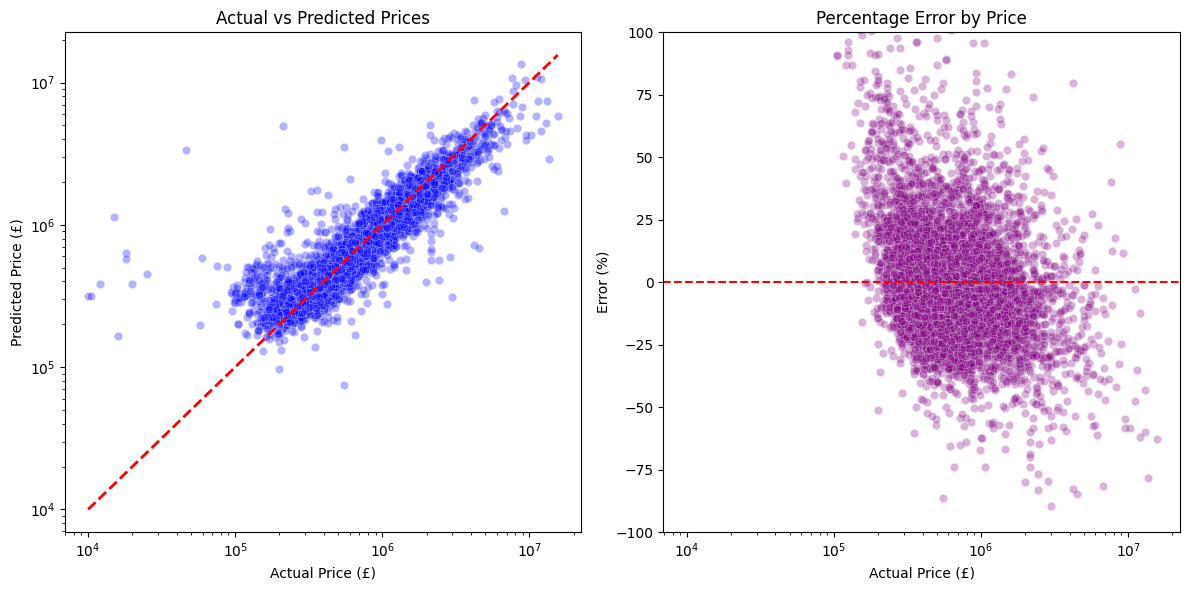

--- Analysis for ~£500k Houses ---
Average Error Amount: £77,081
Average Error %:      15.31%


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for plotting
results = pd.DataFrame({
    'Actual': y_test_real,
    'Predicted': y_pred_real
})

# Calculate the error for each specific house
results['Error_Amount'] = results['Predicted'] - results['Actual']
results['Error_Percent'] = (results['Error_Amount'] / results['Actual']) * 100

plt.figure(figsize=(12, 6))

# Plot 1: Actual vs Predicted
plt.subplot(1, 2, 1)
sns.scatterplot(x='Actual', y='Predicted', data=results, alpha=0.3, color='blue')
# Draw a red line for "Perfect Prediction"
plt.plot([results['Actual'].min(), results['Actual'].max()], 
         [results['Actual'].min(), results['Actual'].max()], 
         color='red', lw=2, linestyle='--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price (£)')
plt.ylabel('Predicted Price (£)')
plt.xscale('log') # Log scale helps see the spread better
plt.yscale('log')

# Plot 2: How big is the error at different price points?
plt.subplot(1, 2, 2)
sns.scatterplot(x='Actual', y='Error_Percent', data=results, alpha=0.3, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.title('Percentage Error by Price')
plt.xlabel('Actual Price (£)')
plt.ylabel('Error (%)')
plt.xscale('log')
plt.ylim(-100, 100) # Zoom in to +/- 100% error

plt.tight_layout()
plt.show()

# Let's check the error specifically for houses around 500k
subset_500k = results[(results['Actual'] > 450000) & (results['Actual'] < 550000)]
avg_error_500k = subset_500k['Error_Amount'].abs().mean()
avg_mape_500k = subset_500k['Error_Percent'].abs().mean()

print(f"--- Analysis for ~£500k Houses ---")
print(f"Average Error Amount: £{avg_error_500k:,.0f}")
print(f"Average Error %:      {avg_mape_500k:.2f}%")

In [ ]:
df_ML['tenure'].unique()

In [ ]:
df_ML.info()

In [4]:
# A. Convert Rooms to Integers
room_cols = ['bathrooms', 'bedrooms', 'livingRooms']
df_ML[room_cols] = df_analysis[room_cols].astype(int)

# B. Label Encode Energy Rating (Ordinal: A=7, G=1, NotRated=0)
energy_map = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1, 'NotRated': 0}
df_ML['energy_encoded'] = df_ML['currentEnergyRating'].map(energy_map)

# C. One-Hot Encoding for categorical columns
# Drop the columns not needed
df_ML = df_ML.drop(columns=['soldT'])
df_ML = pd.get_dummies(df_ML, columns=['propertyType', 'tenure', 'construction_age_band'], drop_first=True, prefix=['prop', 'tenure', 'age'])
X = df_ML.drop(columns=['soldPrice']) 
y = df_ML['soldPrice']

In [6]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Target Encode Outcode (using median sqmPrice)
outcode_medians = X_train.groupby('outcode')['sqmPrice'].median()
global_median = X_train['sqmPrice'].median()
X_train['neighborhood_value'] = X_train['outcode'].map(outcode_medians)

X_test['neighborhood_value'] = X_test['outcode'].map(outcode_medians)
X_test['neighborhood_value'] = X_test['neighborhood_value'].fillna(global_median)

# E. Select final features (excluding the original strings and size_bucket)
final_features = [
    'neighborhood_value', 'bathrooms', 'bedrooms', 'floorAreaSqM', 
    'livingRooms', 'energy_encoded', 'tenure_Freehold', 'in_conservation_area'
] + [col for col in df_ML.columns if 'propertyType_' in col or 'age' in col.lower()]

X_train = X_train[final_features].astype(float) # Convert bools to 1.0/0.0 for the model
X_test = X_test[final_features].astype(float)

Training Random Forest... (this might take a moment)
------------------------------
Model Performance:
------------------------------
R² Score: 0.7932 (The model explains 79.3% of the price variance)
RMSE:     £0 (Root Mean Squared Error)
MAE:      £0 (On average, the prediction is off by this amount)
MAPE:     1.54% (The average error percentage per house)
------------------------------


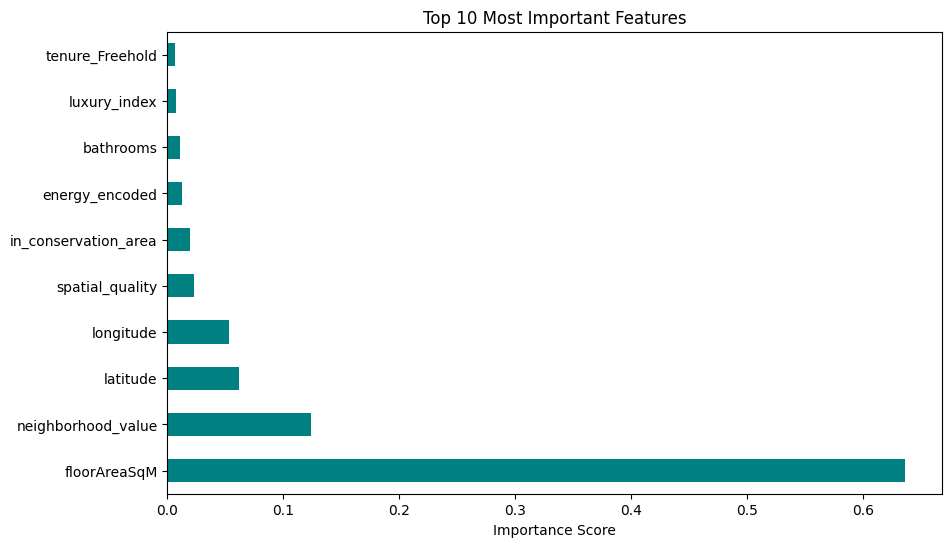

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import numpy as np

# 1. Initialize the Forest
# n_estimators=100: The forest will build 100 decision trees.
# n_jobs=-1: Uses all your computer's processor cores to run faster.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# 2. Train the model (Fit)
print("Training Random Forest... (this might take a moment)")
rf_model.fit(X_train, y_train)

# 3. Predict on Test Data
y_pred = rf_model.predict(X_test)

# 4. Calculate Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 5. Display Results
print("-" * 30)
print("Model Performance:")
print("-" * 30)
print(f"R² Score: {r2:.4f} (The model explains {r2*100:.1f}% of the price variance)")
print(f"RMSE:     £{rmse:,.0f} (Root Mean Squared Error)")
print(f"MAE:      £{mae:,.0f} (On average, the prediction is off by this amount)")
print(f"MAPE:     {mape:.2%} (The average error percentage per house)")
print("-" * 30)

# Optional: Feature Importance
# See what matters most to the model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf_model.feature_importances_
feature_names = X_train.columns
feat_importances = pd.Series(importances, index=feature_names)

plt.figure(figsize=(10,6))
feat_importances.nlargest(10).plot(kind='barh', color='teal')
plt.title("Top 10 Most Important Features")
plt.xlabel("Importance Score")
plt.show()

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import r2_score, mean_absolute_error

# # 1. Select only the physical and neighborhood-value columns
# base_features = [
#     'bathrooms', 
#     'bedrooms', 
#     'floorAreaSqM', 
#     'livingRooms', 
#     'energy_encoded', 
#     'neighborhood_value'
# ]

# # 2. Add the Property Type dummy columns automatically
# property_type_features = [col for col in df_ML.columns if 'propertyType_' in col]

# # 3. Combine them
# final_features = base_features + property_type_features

# X = df_ML[final_features].astype(float) # Convert bools to 1.0/0.0 for the model
# y = df_ML['soldPrice']

# print(f"Model will train on {len(final_features)} features.")

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import r2_score, mean_absolute_error

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize and fit
# rf = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
# rf.fit(X_train, y_train)

# # Predict
# y_pred = rf.predict(X_test)

# # Evaluation
# print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
# print(f"Mean Error: £{mean_absolute_error(y_test, y_pred):,.2f}")

In [ ]:
# import numpy as np
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

# # 1. Split the data (X and y stay as they are)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 2. Transform the training target to Log scale
# y_train_log = np.log1p(y_train)

# # 3. Initialize and fit using the LOG target
# rf = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
# rf.fit(X_train, y_train_log)

# # 4. Predict (output will be in Log scale)
# y_pred_log = rf.predict(X_test)

# # 5. Convert predictions back to original Pounds scale
# y_pred = np.expm1(y_pred_log)

# # 6. Evaluation
# # Note: R2 is still calculated on original y_test vs back-transformed y_pred
# print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
# print(f"Mean Error (MAE): £{mean_absolute_error(y_test, y_pred):,.2f}")
# print(f"Mean Percentage Error (MAPE): {mean_absolute_percentage_error(y_test, y_pred):.2%}")

In [ ]:
# importances = pd.DataFrame({
#     'Feature': X.columns,
#     'Importance': rf.feature_importances_
# }).sort_values(by='Importance', ascending=False)

# plt.figure(figsize=(10, 6))
# sns.barplot(x='Importance', y='Feature', data=importances, palette='viridis', hue='Feature', legend=False)
# plt.title("Random Forest: Feature Importance", fontsize=14, fontweight='bold')
# plt.xlabel("Importance (Relative Contribution to Price)")
# plt.show()

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

# # 1. Create the Luxury Flag (Safely, using Neighborhood Value)
# # We use 15k/sqm as your threshold for a 'Luxury Neighborhood'
# df_ML['is_luxury_area'] = (df_ML['neighborhood_value'] > 15000).astype(int)

# # 2. Define Features (Ensure is_luxury_area is included)
# base_features = [
#     'bathrooms', 'bedrooms', 'floorAreaSqM', 'livingRooms', 
#     'energy_encoded', 'neighborhood_value', 'is_luxury_area'
# ]
# property_type_features = [col for col in df_ML.columns if 'propertyType_' in col]
# final_features = base_features + property_type_features

# X = df_ML[final_features].astype(float)
# y = df_ML['soldPrice']

# # 3. Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 4. Log Transform and Train
# y_train_log = np.log1p(y_train)
# rf = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
# rf.fit(X_train, y_train_log)

# # 5. Predict and Un-log
# y_pred_log = rf.predict(X_test)
# y_pred = np.expm1(y_pred_log)

# # 6. Final Results
# print(f"--- Final Model Results ---")
# print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
# print(f"Mean Error (MAE): £{mean_absolute_error(y_test, y_pred):,.2f}")
# print(f"Mean Percentage Error (MAPE): {mean_absolute_percentage_error(y_test, y_pred):.2%}")